In [62]:
!pip install PyP100
!pip install amberelectric
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [63]:
from PyP100 import PyP110
from pprint import pprint


p110 = PyP110.P110("IP", "user", "passwd") #Creates a P100 plug object


In [64]:
p110.handshake() #Creates the cookies required for further methods
p110.login() #Sends credentials to the plug and creates AES Key and IV for further methods

# p100.turnOn() #Turns the connected plug on
# p100.turnOff() #Turns the connected plug off
# p100.toggleState()
# 
# 
#  #Toggles the state of the connected plug

# p100.turnOnWithDelay(10) #Turns the connected plug on after 10 seconds
# p100.turnOffWithDelay(10) #Turns the connected plug off after 10 seconds

# p100.getDeviceInfo() #Returns dict with all the device info of the connected plug
# p100.getDeviceName() #Returns the name of the connected plug set in the app

In [65]:
deviceName = p110.getDeviceName() #Returns the name of the connected plug set in the app
deviceName

'Smart Plug BYD'

In [ ]:
deviceInfo = p110.getDeviceInfo() #Returns dict with all the device info of the connected plug
pprint(deviceInfo['result'])

In [67]:
energyUsage = p110.getEnergyUsage() #Returns dict with all of the energy usage of the connected plug

In [68]:
pprint(energyUsage['result'])

{'current_power': 1812070,
 'electricity_charge': [0, 0, 0],
 'local_time': '2023-09-28 09:49:23',
 'month_energy': 15281,
 'month_runtime': 974,
 'today_energy': 537,
 'today_runtime': 18}


In [69]:
import json
import logging
import time

def getCurrentPower(pplug):
    URL = f"http://{pplug.ipAddress}/app?token={pplug.token}"
    Payload = {
        "method": "get_current_power", #get_energy_data, get_current_power
        "requestTimeMils": 0,
    }

    headers = {
        "Cookie": pplug.cookie
    }

    EncryptedPayload = pplug.tpLinkCipher.encrypt(json.dumps(Payload))

    SecurePassthroughPayload = {
        "method":"securePassthrough",
        "params":{
            "request": EncryptedPayload
        }
    }
    print("getCurrentPower %s", pplug.ipAddress)
    r = pplug.session.post(URL, json=SecurePassthroughPayload, headers=headers, timeout=2)

    decryptedResponse = pplug.tpLinkCipher.decrypt(r.json()["result"]["response"])

    return json.loads(decryptedResponse)

In [70]:
currentPower = getCurrentPower(p110) #Returns dict with all of the energy usage of the connected plug
pprint(currentPower['result'])

getCurrentPower %s 192.168.1.123
{'current_power': 1812}


# Now we start playing with the Amber API

Library taken from this url https://github.com/madpilot/amberelectric.py/tree/mainv

In [71]:
# Import the library
import amberelectric
from amberelectric.api import amber_api
import pandas as pd


# These are just for demo purposes...

from datetime import date, timedelta

# Insert the API token you created at https://app.amber.com.au/developers
configuration = amberelectric.Configuration(
    access_token = 'YOURTOKEN'
)

# Create an API instance
api = amber_api.AmberApi.create(configuration)

## Fetching Sites
All the interesting functions require a site id, so find one of those first - they can be identified by the National Metering Identifier (NMI)

In [72]:
try:
    sites = api.get_sites()
except amberelectric.ApiException as e:
    print("Exception: %s\n" % e)

In [ ]:
sites[0]

## Fetching Prices

The API allows you to fetch previous, current and forecast prices by day.

If no start_date or end_date is supplied, it default to the current day.

Note: If duration is 30, there will be 48 intervals per channel. A duration of 5 returns 288 intervals.

In [74]:

site_id = sites[0].id
try:
    # Get the current date
    current_date = date.today()

    # Calculate the date one week ago
    one_week_ago = current_date - timedelta(days=7)
    range = api.get_prices(site_id, start_date=one_week_ago, end_date=current_date)
    today = api.get_prices(site_id)
except amberelectric.ApiException as e:
    print("Exception: %s\n" % e)

In [75]:
rangeDict = [i.to_dict() for i in range]
rangeDf = pd.DataFrame(rangeDict)
rangeDf

,duration,spot_per_kwh,per_kwh,date,nem_time,start_time,end_time,renewables,channel_type,spike_status,descriptor,type
0,30.0,-5.40508,9.95114,2023-09-20,2023-09-20 00:30:00+10:00,2023-09-19 14:00:01+00:00,2023-09-19 14:30:00+00:00,72.608,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,ActualInterval
1,30.0,-5.12985,10.24100,2023-09-20,2023-09-20 01:00:00+10:00,2023-09-19 14:30:01+00:00,2023-09-19 15:00:00+00:00,73.551,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,ActualInterval
2,30.0,-5.34361,10.01588,2023-09-20,2023-09-20 01:30:00+10:00,2023-09-19 15:00:01+00:00,2023-09-19 15:30:00+00:00,73.396,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,ActualInterval
3,30.0,-5.81087,9.52379,2023-09-20,2023-09-20 02:00:00+10:00,2023-09-19 15:30:01+00:00,2023-09-19 16:00:00+00:00,72.160,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,ActualInterval
4,30.0,-6.11231,9.20633,2023-09-20,2023-09-20 02:30:00+10:00,2023-09-19 16:00:01+00:00,2023-09-19 16:30:00+00:00,72.372,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,ActualInterval
...,...,...,...,...,...,...,...,...,...,...,...,...
1147,30.0,7.32272,-7.36525,2023-09-27,2023-09-27 22:00:00+10:00,2023-09-27 11:30:01+00:00,2023-09-27 12:00:00+00:00,19.963,ChannelType.FEED_IN,SpikeStatus.NO_SPIKE,Descriptor.HIGH,ActualInterval
1148,30.0,7.60373,-7.63429,2023-09-27,2023-09-27 22:30:00+10:00,2023-09-27 12:00:01+00:00,2023-09-27 12:30:00+00:00,22.214,ChannelType.FEED_IN,SpikeStatus.NO_SPIKE,Descriptor.HIGH,ActualInterval
1149,30.0,7.54331,-7.57644,2023-09-27,2023-09-27 23:00:00+10:00,2023-09-27 12:30:01+00:00,2023-09-27 13:00:00+00:00,22.365,ChannelType.FEED_IN,SpikeStatus.NO_SPIKE,Descriptor.HIGH,ActualInterval
1150,30.0,7.65591,-7.68424,2023-09-27,2023-09-27 23:30:00+10:00,2023-09-27 13:00:01+00:00,2023-09-27 13:30:00+00:00,18.614,ChannelType.FEED_IN,SpikeStatus.NO_SPIKE,Descriptor.HIGH,ActualInterval


In [76]:
todayDict = [i.to_dict() for i in today]
todayDf = pd.DataFrame(todayDict)
todayDf

,duration,spot_per_kwh,per_kwh,date,nem_time,start_time,end_time,renewables,channel_type,spike_status,descriptor,type,range,estimate
0,30.0,7.39600,23.43243,2023-09-28,2023-09-28 00:30:00+10:00,2023-09-27 14:00:01+00:00,2023-09-27 14:30:00+00:00,17.283000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
1,30.0,7.04250,23.06014,2023-09-28,2023-09-28 01:00:00+10:00,2023-09-27 14:30:01+00:00,2023-09-27 15:00:00+00:00,19.181000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
2,30.0,6.58209,22.57527,2023-09-28,2023-09-28 01:30:00+10:00,2023-09-27 15:00:01+00:00,2023-09-27 15:30:00+00:00,18.807000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
3,30.0,5.56320,21.50224,2023-09-28,2023-09-28 02:00:00+10:00,2023-09-27 15:30:01+00:00,2023-09-27 16:00:00+00:00,19.778000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
4,30.0,5.38554,21.31514,2023-09-28,2023-09-28 02:30:00+10:00,2023-09-27 16:00:01+00:00,2023-09-27 16:30:00+00:00,20.893000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,30.0,7.70000,-7.72646,2023-09-28,2023-09-28 22:00:00+10:00,2023-09-28 11:30:01+00:00,2023-09-28 12:00:00+00:00,11.718395,ChannelType.FEED_IN,SpikeStatus.NO_SPIKE,Descriptor.HIGH,ForecastInterval,"{'min': 6.04261, 'max': 70.11847}",NaN
140,30.0,7.70000,-7.72646,2023-09-28,2023-09-28 22:30:00+10:00,2023-09-28 12:00:01+00:00,2023-09-28 12:30:00+00:00,12.560967,ChannelType.FEED_IN,SpikeStatus.NO_SPIKE,Descriptor.HIGH,ForecastInterval,"{'min': 6.11355, 'max': 98.396}",NaN
141,30.0,8.95648,-8.92940,2023-09-28,2023-09-28 23:00:00+10:00,2023-09-28 12:30:01+00:00,2023-09-28 13:00:00+00:00,13.303090,ChannelType.FEED_IN,SpikeStatus.NO_SPIKE,Descriptor.HIGH,ForecastInterval,"{'min': 5.95693, 'max': 41.54001}",NaN
142,30.0,8.88365,-8.85968,2023-09-28,2023-09-28 23:30:00+10:00,2023-09-28 13:00:01+00:00,2023-09-28 13:30:00+00:00,13.909255,ChannelType.FEED_IN,SpikeStatus.NO_SPIKE,Descriptor.HIGH,ForecastInterval,"{'min': 5.9452, 'max': 32.27333}",NaN


filter only by channel Type General

In [77]:
# Filter the DataFrame based on a value in a specific column
from amberelectric.model.channel import ChannelType

def filterIntervalDf( df, value = ChannelType.GENERAL ):

    target_value = value
    filtered_df = df[df['channel_type'] == target_value]
    return filtered_df

In [78]:
filteredTodayDf = filterIntervalDf( todayDf )
filteredTodayDf


,duration,spot_per_kwh,per_kwh,date,nem_time,start_time,end_time,renewables,channel_type,spike_status,descriptor,type,range,estimate
0,30.0,7.39600,23.43243,2023-09-28,2023-09-28 00:30:00+10:00,2023-09-27 14:00:01+00:00,2023-09-27 14:30:00+00:00,17.283000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
1,30.0,7.04250,23.06014,2023-09-28,2023-09-28 01:00:00+10:00,2023-09-27 14:30:01+00:00,2023-09-27 15:00:00+00:00,19.181000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
2,30.0,6.58209,22.57527,2023-09-28,2023-09-28 01:30:00+10:00,2023-09-27 15:00:01+00:00,2023-09-27 15:30:00+00:00,18.807000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
3,30.0,5.56320,21.50224,2023-09-28,2023-09-28 02:00:00+10:00,2023-09-27 15:30:01+00:00,2023-09-27 16:00:00+00:00,19.778000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
4,30.0,5.38554,21.31514,2023-09-28,2023-09-28 02:30:00+10:00,2023-09-27 16:00:01+00:00,2023-09-27 16:30:00+00:00,20.893000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
5,30.0,5.31945,21.24554,2023-09-28,2023-09-28 03:00:00+10:00,2023-09-27 16:30:01+00:00,2023-09-27 17:00:00+00:00,20.600000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
6,30.0,5.66202,21.60631,2023-09-28,2023-09-28 03:30:00+10:00,2023-09-27 17:00:01+00:00,2023-09-27 17:30:00+00:00,18.703000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
7,30.0,5.57249,21.51202,2023-09-28,2023-09-28 04:00:00+10:00,2023-09-27 17:30:01+00:00,2023-09-27 18:00:00+00:00,18.274000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
8,30.0,6.72875,22.72972,2023-09-28,2023-09-28 04:30:00+10:00,2023-09-27 18:00:01+00:00,2023-09-27 18:30:00+00:00,18.141000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN
9,30.0,7.24824,23.27682,2023-09-28,2023-09-28 05:00:00+10:00,2023-09-27 18:30:01+00:00,2023-09-27 19:00:00+00:00,16.109000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,ActualInterval,NaN,NaN


You can also just ask for the current price

In [79]:
try:
    current = api.get_current_price(site_id)
except amberelectric.ApiException as e:
    print("Exception: %s\n" % e)

In [80]:
def extractCurrentPriceByChannel( data, value = ChannelType.GENERAL ):
    currentPrice = [d.per_kwh for d in data if d.channel_type == value]
    return currentPrice[0]

print(extractCurrentPriceByChannel(current, ChannelType.GENERAL))

13.30209


In [81]:
currentDict = [i.to_dict() for i in current]
currentDf = pd.DataFrame(currentDict)
currentDf

,duration,spot_per_kwh,per_kwh,date,nem_time,start_time,end_time,renewables,channel_type,spike_status,descriptor,type,range,estimate
0,30.0,-2.22321,13.30209,2023-09-28,2023-09-28 10:00:00+10:00,2023-09-27 23:30:01+00:00,2023-09-28 00:00:00+00:00,53.398,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,CurrentInterval,None,True
1,30.0,-2.22321,6.36109,2023-09-28,2023-09-28 10:00:00+10:00,2023-09-27 23:30:01+00:00,2023-09-28 00:00:00+00:00,53.398,ChannelType.CONTROLLED_LOAD,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,CurrentInterval,None,True
2,30.0,-2.22321,1.77399,2023-09-28,2023-09-28 10:00:00+10:00,2023-09-27 23:30:01+00:00,2023-09-28 00:00:00+00:00,53.398,ChannelType.FEED_IN,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,CurrentInterval,None,True


and the current price plus some number of previous and next intervals

In [82]:
try:
    currentAndForecast = api.get_current_price(site_id, next=4)
    # returns the current interval and the next 4 forecast intervasl
except amberelectric.ApiException as e:
    print("Exception: %s\n" % e)

In [83]:
currentAndForecastDict = [i.to_dict() for i in currentAndForecast]
currentAndForecastDf = pd.DataFrame(currentAndForecastDict)
filterIntervalDf(currentAndForecastDf)

,duration,spot_per_kwh,per_kwh,date,nem_time,start_time,end_time,renewables,channel_type,spike_status,descriptor,type,range,estimate
0,30.0,-2.22321,13.30209,2023-09-28,2023-09-28 10:00:00+10:00,2023-09-27 23:30:01+00:00,2023-09-28 00:00:00+00:00,53.398000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,CurrentInterval,None,True
1,30.0,-4.69765,10.69616,2023-09-28,2023-09-28 10:30:00+10:00,2023-09-28 00:00:01+00:00,2023-09-28 00:30:00+00:00,58.083000,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,ForecastInterval,None,NaN
2,30.0,-2.18720,13.34001,2023-09-28,2023-09-28 11:00:00+10:00,2023-09-28 00:30:01+00:00,2023-09-28 01:00:00+00:00,65.993674,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,ForecastInterval,"{'min': -5.255, 'max': 1.33418}",NaN
3,30.0,-5.50110,9.85002,2023-09-28,2023-09-28 11:30:00+10:00,2023-09-28 01:00:01+00:00,2023-09-28 01:30:00+00:00,68.855344,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,ForecastInterval,"{'min': -6.0, 'max': 0.31469}",NaN
4,30.0,-5.48570,9.86624,2023-09-28,2023-09-28 12:00:00+10:00,2023-09-28 01:30:01+00:00,2023-09-28 02:00:00+00:00,72.655340,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.EXTREMELY_LOW,ForecastInterval,"{'min': -6.143, 'max': 0.20353}",NaN


## Usage
You can request your usage for a given day.

In [84]:
try:
    # Get the current date
    current_date = date.today() 

    # Calculate the date one week ago
    one_week_ago = current_date - timedelta(days=1)

    usage = api.get_usage(site_id, one_week_ago, current_date)
except amberelectric.ApiException as e:
    print("Exception: %s\n" % e)

In [85]:
usageDict = [i.to_dict() for i in usage]
usageDf = pd.DataFrame(usageDict)
filteredUsageDf = filterIntervalDf(usageDf)
filteredUsageDf

,duration,spot_per_kwh,per_kwh,date,nem_time,start_time,end_time,renewables,channel_type,spike_status,descriptor,type,channelIdentifier,kwh,quality,cost
0,30.0,8.09448,24.16802,2023-09-26,2023-09-26 00:30:00+10:00,2023-09-25 14:00:01+00:00,2023-09-25 14:30:00+00:00,21.414,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,Usage,E1,0.391,billable,9.4497
1,30.0,7.45345,23.49293,2023-09-26,2023-09-26 01:00:00+10:00,2023-09-25 14:30:01+00:00,2023-09-25 15:00:00+00:00,23.178,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,Usage,E1,0.062,billable,1.4566
2,30.0,7.23989,23.26802,2023-09-26,2023-09-26 01:30:00+10:00,2023-09-25 15:00:01+00:00,2023-09-25 15:30:00+00:00,22.793,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,Usage,E1,0.078,billable,1.8149
3,30.0,7.13075,23.15308,2023-09-26,2023-09-26 02:00:00+10:00,2023-09-25 15:30:01+00:00,2023-09-25 16:00:00+00:00,22.204,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,Usage,E1,0.055,billable,1.2734
4,30.0,6.98458,22.99915,2023-09-26,2023-09-26 02:30:00+10:00,2023-09-25 16:00:01+00:00,2023-09-25 16:30:00+00:00,22.711,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,Usage,E1,0.067,billable,1.5409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,30.0,7.32272,23.35525,2023-09-27,2023-09-27 22:00:00+10:00,2023-09-27 11:30:01+00:00,2023-09-27 12:00:00+00:00,19.963,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,Usage,E1,0.556,billable,12.9855
92,30.0,7.60373,23.65120,2023-09-27,2023-09-27 22:30:00+10:00,2023-09-27 12:00:01+00:00,2023-09-27 12:30:00+00:00,22.214,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,Usage,E1,0.427,billable,10.0991
93,30.0,7.54331,23.58756,2023-09-27,2023-09-27 23:00:00+10:00,2023-09-27 12:30:01+00:00,2023-09-27 13:00:00+00:00,22.365,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,Usage,E1,0.426,billable,10.0483
94,30.0,7.65591,23.70615,2023-09-27,2023-09-27 23:30:00+10:00,2023-09-27 13:00:01+00:00,2023-09-27 13:30:00+00:00,18.614,ChannelType.GENERAL,SpikeStatus.NO_SPIKE,Descriptor.VERY_LOW,Usage,E1,0.252,billable,5.9739


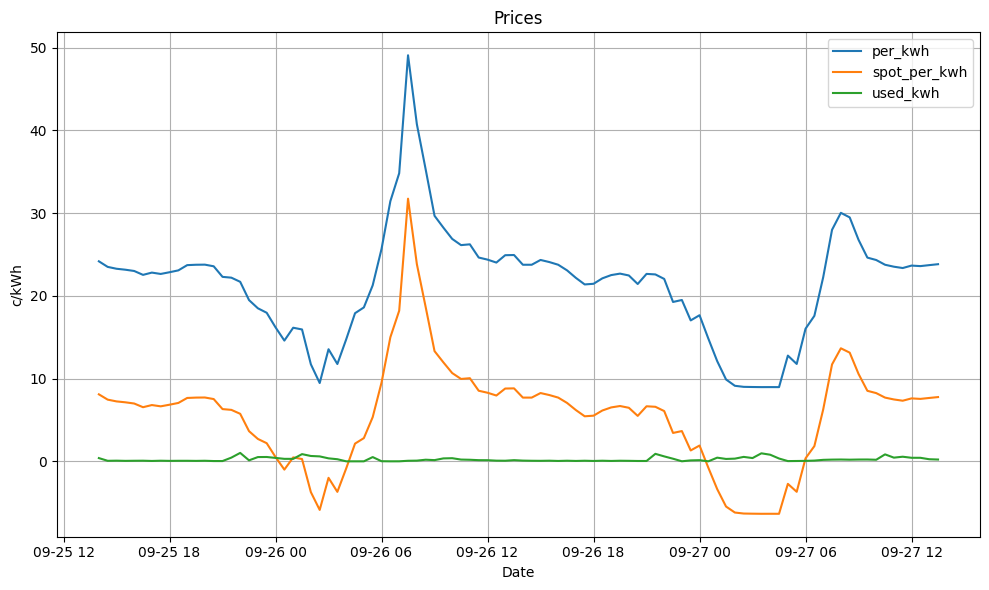

In [86]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(filteredUsageDf['start_time'], filteredUsageDf['per_kwh'], label='per_kwh')
plt.plot(filteredUsageDf['start_time'], filteredUsageDf['spot_per_kwh'], label='spot_per_kwh')
plt.plot(filteredUsageDf['start_time'], filteredUsageDf['kwh'], label='used_kwh')
plt.xlabel('Date')
plt.ylabel('c/kWh')
plt.title('Prices')
plt.legend()
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

NameError: name 'DateFormatter' is not defined

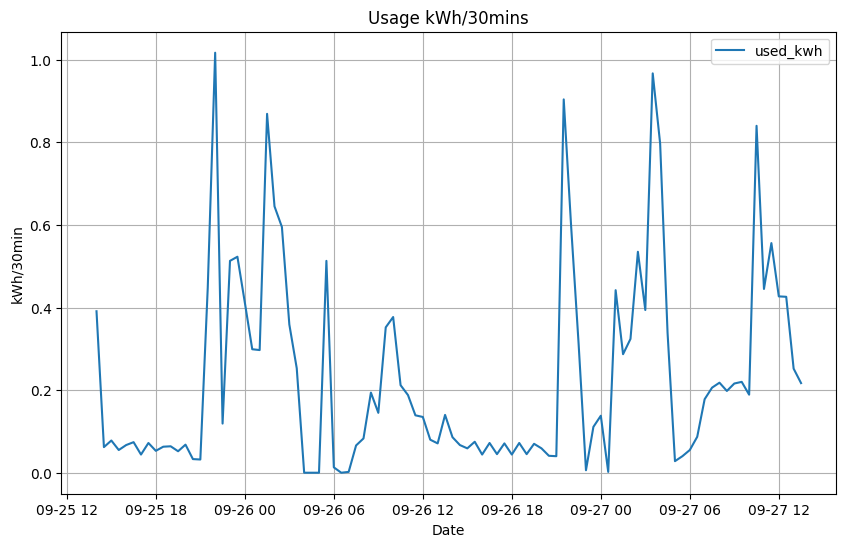

In [87]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(filteredUsageDf['start_time'], filteredUsageDf['kwh'], label='used_kwh')
plt.xlabel('Date')
plt.ylabel('kWh/30min')
plt.title('Usage kWh/30mins')
plt.legend()
plt.grid(True)

# Formatting the x-axis labels

date_format = '%Y-%m-%d %H:%M'
date_form = DateFormatter(date_format)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_formatter(date_form)

# Display the plot
plt.tight_layout()
plt.show()

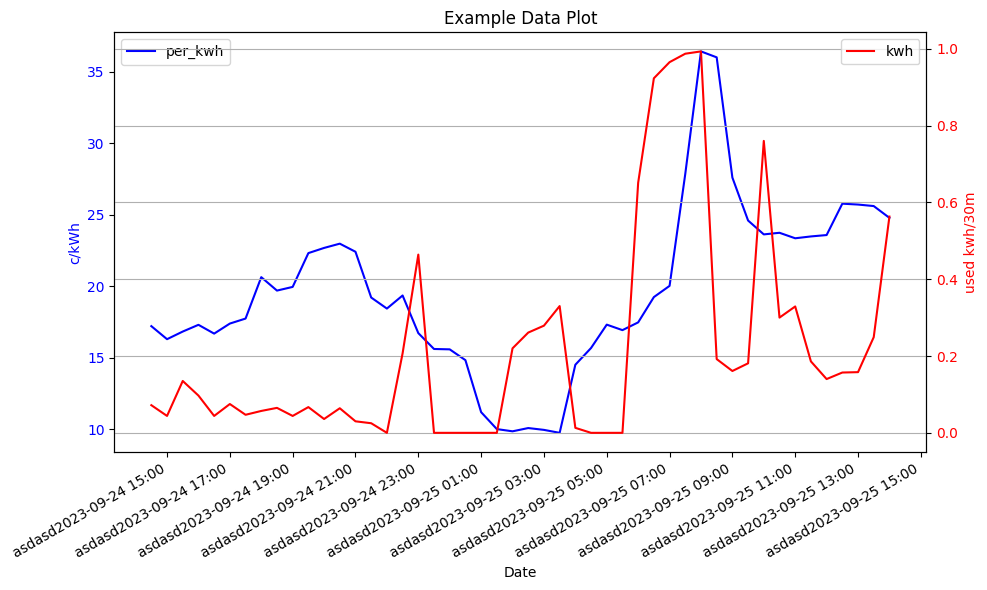

In [ ]:
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates



# Create a DataFrame from the example data
df = filteredUsageDf

# Convert the 'start_time' column to datetime objects
#df['start_time'] = pd.to_datetime(df['start_time'])

# Create a figure and two axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'per_kwh' on the left y-axis
ax1.plot(df['nem_time'], df['per_kwh'], label='per_kwh', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('c/kWh', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Create a second y-axis on the right
ax2 = ax1.twinx()
ax2.plot(df['nem_time'], df['kwh'], label='kwh', color='r')
ax2.set_ylabel('used kwh/30m', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

# Title and grid
plt.title('Example Data Plot')
plt.grid(True)

# Formatting the x-axis labels

date_format = '%Y-%m-%d %H:%M'
date_form = DateFormatter(date_format)
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)


# Rotate x-axis labels for better readability (optional)
fig.autofmt_xdate()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
df['nem_time']

0    2023-09-25 00:30:00+10:00
1    2023-09-25 01:00:00+10:00
2    2023-09-25 01:30:00+10:00
3    2023-09-25 02:00:00+10:00
4    2023-09-25 02:30:00+10:00
5    2023-09-25 03:00:00+10:00
6    2023-09-25 03:30:00+10:00
7    2023-09-25 04:00:00+10:00
8    2023-09-25 04:30:00+10:00
9    2023-09-25 05:00:00+10:00
10   2023-09-25 05:30:00+10:00
11   2023-09-25 06:00:00+10:00
12   2023-09-25 06:30:00+10:00
13   2023-09-25 07:00:00+10:00
14   2023-09-25 07:30:00+10:00
15   2023-09-25 08:00:00+10:00
16   2023-09-25 08:30:00+10:00
17   2023-09-25 09:00:00+10:00
18   2023-09-25 09:30:00+10:00
19   2023-09-25 10:00:00+10:00
20   2023-09-25 10:30:00+10:00
21   2023-09-25 11:00:00+10:00
22   2023-09-25 11:30:00+10:00
23   2023-09-25 12:00:00+10:00
24   2023-09-25 12:30:00+10:00
25   2023-09-25 13:00:00+10:00
26   2023-09-25 13:30:00+10:00
27   2023-09-25 14:00:00+10:00
28   2023-09-25 14:30:00+10:00
29   2023-09-25 15:00:00+10:00
30   2023-09-25 15:30:00+10:00
31   2023-09-25 16:00:00+10:00
32   202